En este laboratorio aprenderemos cómo usar una red neuronal pre-entrenada para
un problema más específico. Primero descargamos el conjunto de imágenes de un
problema muy específico: clasificar perros y gatos. Dada la cantidad de imágenes
de este dataset específico, no podríamos entrenar una red neuronal profunda para
clasificar este dataset. Una red neuronal convolucional profunda tiene muchos
parámetros y muy probablemente sólo obtendríamos un modelo con overfitting.


In [1]:
!wget www.ivan-sipiran.com/downloads/dogvscat.zip

--2024-07-01 19:59:31--  http://www.ivan-sipiran.com/downloads/dogvscat.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91262705 (87M) [application/zip]
Saving to: ‘dogvscat.zip.1’

dogvscat.zip.1      100%[===================>]  87.03M  20.6MB/s    in 5.2s    

2024-07-01 19:59:36 (16.9 MB/s) - ‘dogvscat.zip.1’ saved [91262705/91262705]



In [2]:
!unzip dogvscat.zip

Archive:  dogvscat.zip
replace dogvscat/train/cat/cat.3399.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Cuando tenemos un dataset organizado en carpetas, como en el ejemplo, podemos
cargarlas en Keras de manera muy fácil usando 'image_dataset_from_directory'


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

#Esta función recibe como parámetros:
#    - la carpeta desde donde cargar las imágenes
#    - shuffle: mezcla la data para el entrenamiento
#    - batch_size: tamaño del batch para entrenamiento
#    - image_size: tamaño de las imágenes (todas las imágenes serán de este tamaño)
X_train = image_dataset_from_directory('dogvscat/train',
                                        shuffle=True,
                                        batch_size=32,
                                        label_mode='categorical',
                                        image_size=(150, 150))
X_test = image_dataset_from_directory('dogvscat/val',
                                       shuffle=True,
                                       batch_size=32,
                                       label_mode='categorical',
                                       image_size=(150, 150))

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Es usual aplicar ciertas transformaciones a las imágenes para hacer el
entrenamiento más robusto.


In [5]:
data_augmentation_layers = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

Visualizamos los resultados de 12 transformaciones aplicadas en una imagen


2024-07-01 20:00:19.952519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


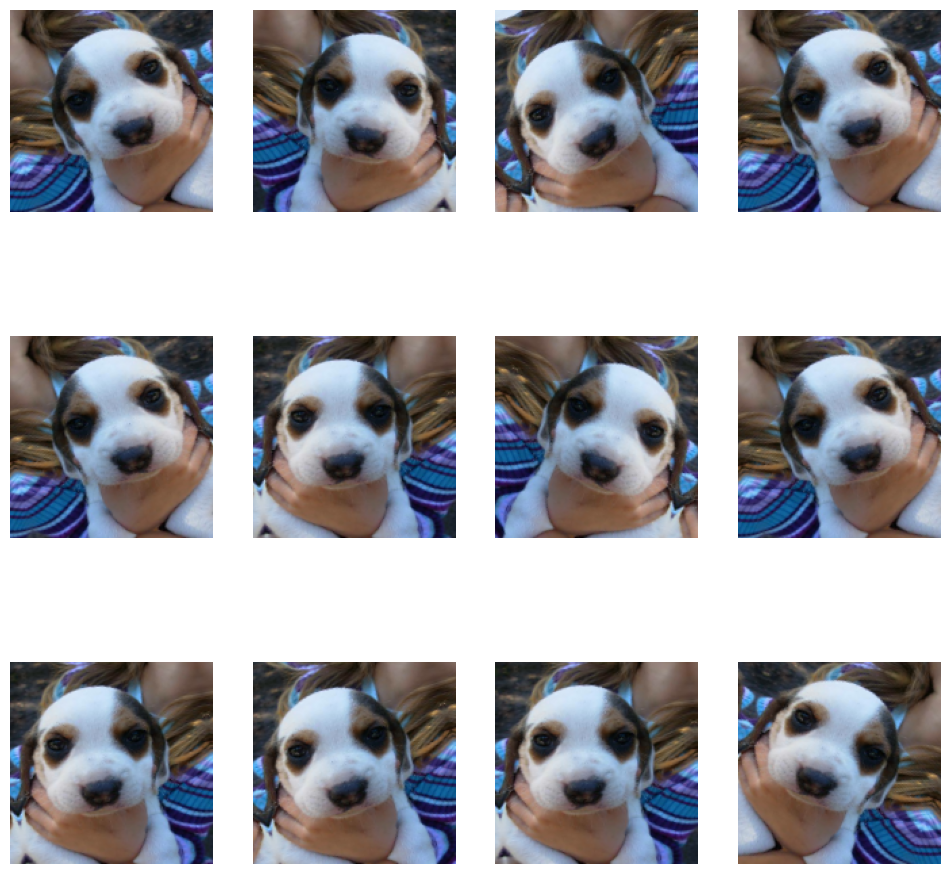

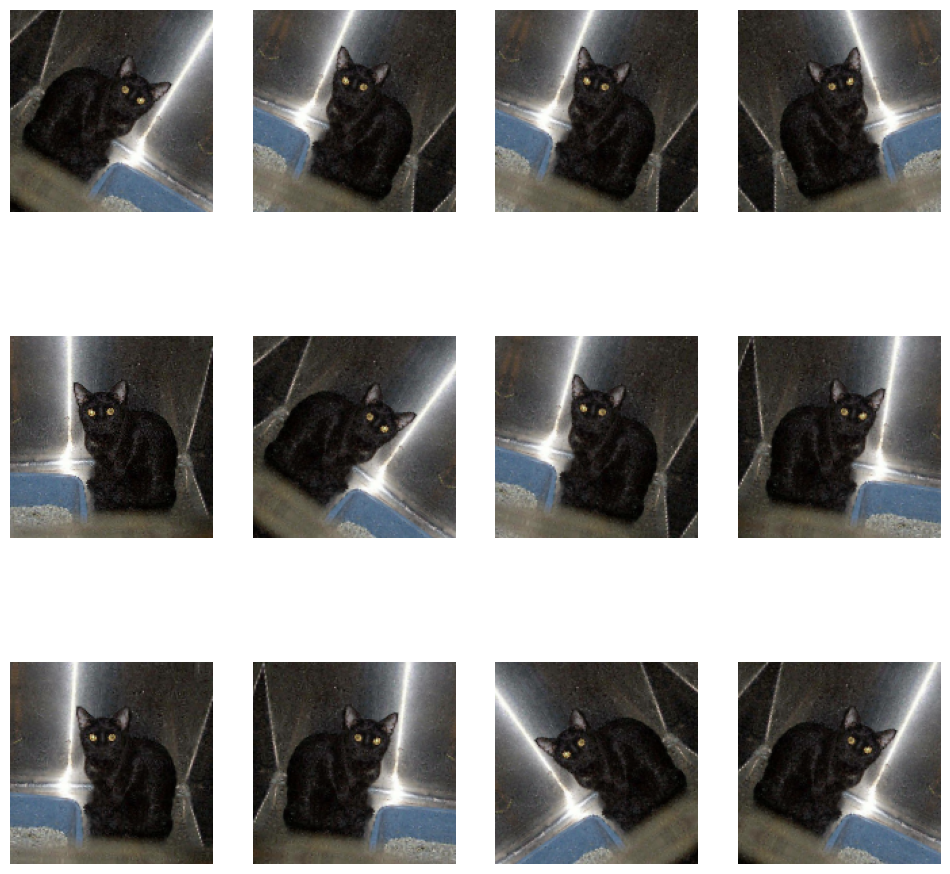

In [6]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in X_train.take(2):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation_layers(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [7]:
base_model = keras.applications.ResNet50(weights='imagenet',  input_shape=(150, 150, 3), include_top=False)

In [8]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
base_model.trainable = False

In [10]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation_layers(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x) #Obligatorio

In [11]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  #Opcional
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
hist=model.fit(X_train, epochs=20, validation_data=X_test)

Epoch 1/20


/Users/oxfist/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 527ms/step - accuracy: 0.8337 - loss: 0.3917 - val_accuracy: 0.9550 - val_loss: 0.1068
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 517ms/step - accuracy: 0.9510 - loss: 0.1197 - val_accuracy: 0.9750 - val_loss: 0.0918
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 510ms/step - accuracy: 0.9653 - loss: 0.0843 - val_accuracy: 0.9680 - val_loss: 0.0932
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 506ms/step - accuracy: 0.9646 - loss: 0.0880 - val_accuracy: 0.9690 - val_loss: 0.0853
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 515ms/step - accuracy: 0.9672 - loss: 0.0796 - val_accuracy: 0.9730 - val_loss: 0.0782
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 513ms/step - accuracy: 0.9680 - loss: 0.0986 - val_accuracy: 0.9770 - val_loss: 0.0721
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - accuracy: 0.9741 - loss: 0.0616 - val_accuracy: 0.9750 - val_loss: 0.0727
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 515ms/step - accuracy: 0.9820 - loss: 0.0524 - val_accuracy: 0.976

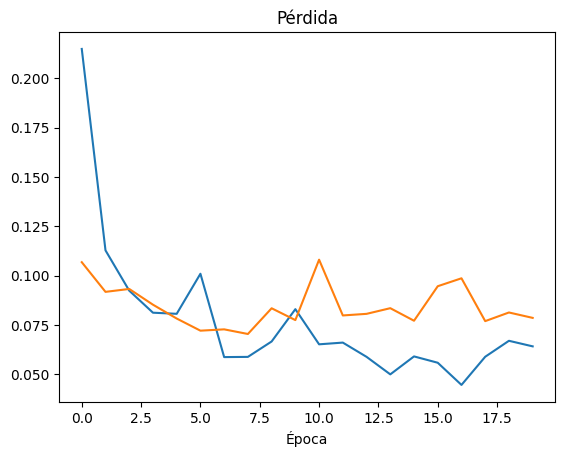

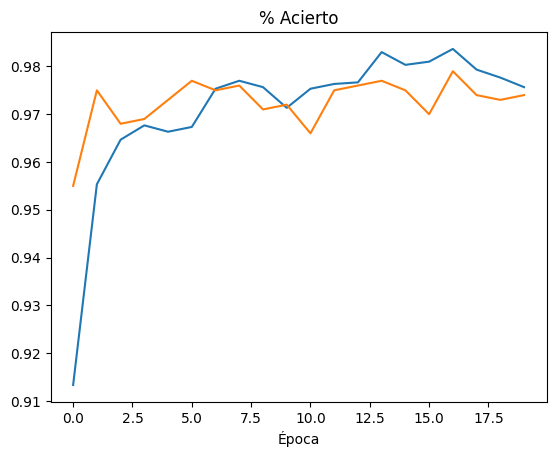

In [13]:
# Mostramos la pérdida y el acierto por cada época

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()

Ahora aplicamos fine-tuning


In [14]:
base_model.trainable = True

Hacemos un entrenamiento con un learning rate muy pequeño, solo queremos ajustar
los resultados, no queremos que cambien mucho.


In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

log = "checkpoint.weights.h5"
callbacks = [
    EarlyStopping(patience=5),
    ModelCheckpoint(
        filepath=log,
        save_weights_only=True,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
    ),
]

In [19]:
hist2 = model.fit(X_train, epochs=5, validation_data=X_test, callbacks=callbacks)

Epoch 1/5


/Users/oxfist/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


94/94 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9110 - loss: 0.2578 - val_accuracy: 0.9740 - val_loss: 0.0819
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9584 - loss: 0.0929 - val_accuracy: 0.9750 - val_loss: 0.0740
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9730 - loss: 0.0774 - val_accuracy: 0.9740 - val_loss: 0.0756
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9748 - loss: 0.0644 - val_accuracy: 0.9770 - val_loss: 0.0704
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9792 - loss: 0.0557 - val_accuracy: 0.9760 - val_loss: 0.0733


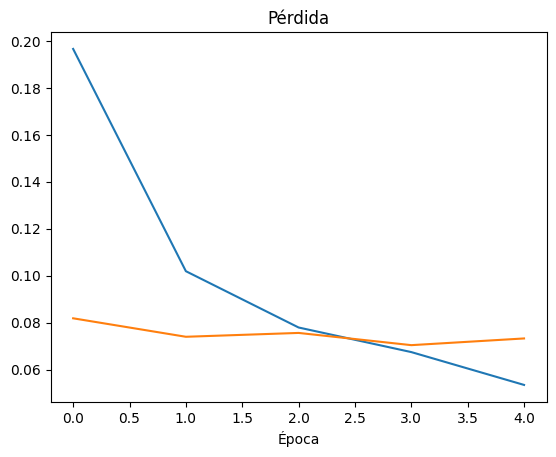

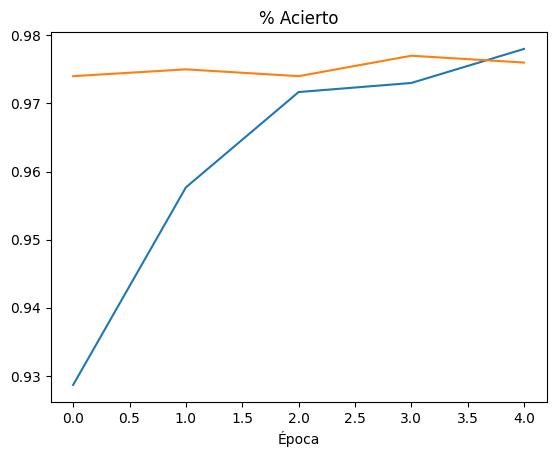

In [20]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()

Cargamos el mejor modelo y hacemos algunas predicciones


In [21]:
model.load_weights('checkpoint.weights.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

img_path = 'dogvscat/val/cat/cat.10007.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)

preds = model.predict(x)
print(preds.shape)
preds = preds.reshape(2)
print(preds.shape)
lpred = np.argmax(preds)
print(lpred)

plt.imshow(img)
plt.title(['Cat' if lpred==0 else 'Dog'])
plt.show()
